# Muhammad Musa
# CS 760
# HW 4

In [112]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Question 4
(Question 3 after this)

In [88]:

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)


def to_categorical(x, n_col=None):
    if n_col == None:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot


def cross_entropy_loss(h_x, y):
    h_x = np.clip(h_x, 1e-15, 1-1e-15)
    return (-(y * np.log(h_x))).sum(axis=1).mean()


def sigmoid(x):
    x = np.clip(x, -500, 500) 
    sigmoid = 1/(1+np.exp(-x))
    return sigmoid


def fit(W1, W2, lr = 0.1, epochs = 2000, X_train = None, Y_train = None):
    
    losses = []
    for _ in tqdm(range(epochs)):
    
        ################################
        ##### FORWARD PROPAGATION ######
        ################################
        
        # W1 and W2 are weights
        running_loss = 0
        for i in range(len(X_train)):
            x_train = X_train[i]
            y_train = Y_train[i]
            a_1 = sigmoid(x_train.dot(W1.T)) # m x d1
            y_hat = softmax(a_1.dot(W2.T))     # m x k
            loss = cross_entropy_loss(y_hat, y_train)
            
            ################################
            ##### BACKWARD PROPAGATION #####
            ################################
            
            # W2 updates:
            delta2 = (y_hat - y_train )           # m x k
            # print(delta2.sum())
            W2_update = (a_1.T.dot(delta2)/x_train.shape[0]).T   # k x d1
            
            # W1 updates
            sigmoid_gradient = a_1 * (1-a_1)            # m x d1
            delta1 = delta2.dot(W2) * sigmoid_gradient  # m x d1
            W1_update = (x_train.T.dot(delta1)/x_train.shape[0]).T       # d1 x d
            
            ################################
            ####### GRADIENT DESCENT #######
            ################################
            # print(W2.sum(), "pehle")
            W2 = W2 - lr*W2_update
            W1 = W1 - lr*W1_update
            running_loss += loss

        avg_loss = running_loss / len(X_train)
        losses.append(avg_loss)

    return W1, W2, losses
    
def predictions(x_test, W1, W2):
    a_1 = sigmoid(x_test.dot(W1.T))     # m x d1 
    y_hat = sigmoid(a_1.dot(W2.T))      # m x k
    return y_hat

## NN From Scratch
For the from scratch network, I am using the mnist dataset from keras and instead of using a dataloader, I am making batches myself. 

In [87]:
d1 = 300


X_train = train_images.reshape(np.shape(train_images)[0],-1)/255
X_test = test_images.reshape(np.shape(test_images)[0],-1)/255
Y_train = to_categorical(train_labels,10)
Y_test = to_categorical(test_labels,10)

# Initializing W1 and W2 using total numebr of features
limit_W1   = 1 / math.sqrt(X_train.shape[1])
W1  = np.random.uniform(-limit_W1, limit_W1, (d1, X_train.shape[1]))
limit_W2   = 1 / math.sqrt(d1)
W2  = np.random.uniform(-limit_W2, limit_W2, (Y_train.shape[1], d1))

# making batches from batch size
batch_size = 32
num_samples = len(X_train)
num_batches = num_samples // batch_size
X_train_b, Y_train_b = [], []

for i in range(num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    x = X_train[start:end]
    y = Y_train[start:end]
    X_train_b.append(x)
    Y_train_b.append(y)

# For the ones left over I am using batch size 32, in which case there won;t be any left overs, but for batch isze 64, there are)
if num_samples % batch_size != 0:
    start = num_batches * batch_size
    x = X_train[start:]
    y = Y_train[start:]
    X_train_b.append(x)
    Y_train_b.append(y)


In [89]:
losses = fit(W1, W2, 0.01, epochs = 200, X_train=X_train_b, Y_train=Y_train_b)

100%|██████████| 200/200 [25:32<00:00,  7.66s/it]


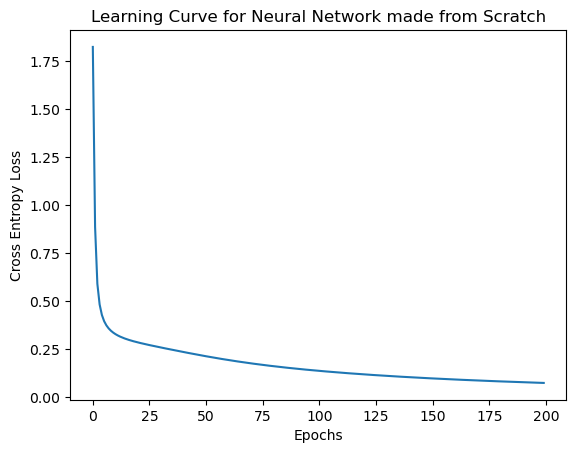

In [93]:
plt.plot(losses[-1])
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Learning Curve for Neural Network made from Scratch")
plt.show()

In [95]:
y_pred = predictions(X_test, losses[0], losses[1])
count_self = 0 
for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(Y_test[i]):
        count_self +=1 
print("Accuracy:",count_self*100/len(y_pred))
print("Test Error:",1 - (count_self/len(y_pred)))

Accuracy: 97.18
Test Error: 0.028200000000000003


## Running the NN using TensorFlow

In [102]:
# We have already loaded MNIST dataset but loading it again here to make sure no previous changes effect dataset for these models
# preprocessing again as this time I am not flattening it myslef, but will instead add a flatten layer in the model
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
d1 = 300

def tf_model(d1= 300, epochs = 200, bs= 64, uni_w = False, W0 = False,verbose = 0, test_images = test_images, train_images = train_images, test_labels = test_labels, train_labels = train_labels):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))

    if uni_w:
        def random_weights(shape, dtype=None):
            return tf.random.uniform(shape, minval=-1, maxval=1, dtype=dtype)
        model.add(layers.Dense(d1, activation='sigmoid', kernel_initializer=random_weights))
        model.add(layers.Dense(10, activation='softmax', kernel_initializer = random_weights))
        
    elif W0:
        model.add(layers.Dense(d1, activation='sigmoid', kernel_initializer=initializers.Zeros()))
        model.add(layers.Dense(10, activation='softmax', kernel_initializer = initializers.Zeros()))

    else:
        model.add(layers.Dense(d1, activation='sigmoid'))
        model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=bs, verbose = verbose)
    _, test_acc = model.evaluate(test_images, test_labels)
    
    return test_acc, history.history['loss']

## Running Code for Part 2 of Question 4 (without manual initialization of weights)

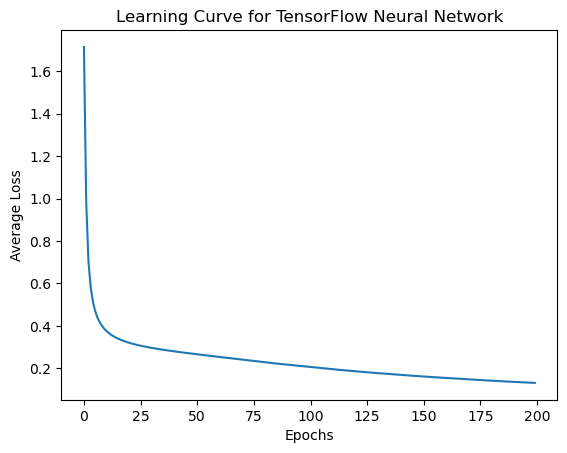

Test accuracy: 95.95999717712402
Test error: 0.040400028228759766


In [111]:
test_acc, loss = tf_model()

plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title("Learning Curve for TensorFlow Neural Network")
plt.show()

print("Test accuracy:", test_acc*100)
print("Test error:", 1 - test_acc)


## Running tensorflow NN with initialization of weights to 0

313/313 [==============================] - 1s 2ms/step - loss: 1.5379 - accuracy: 0.3895


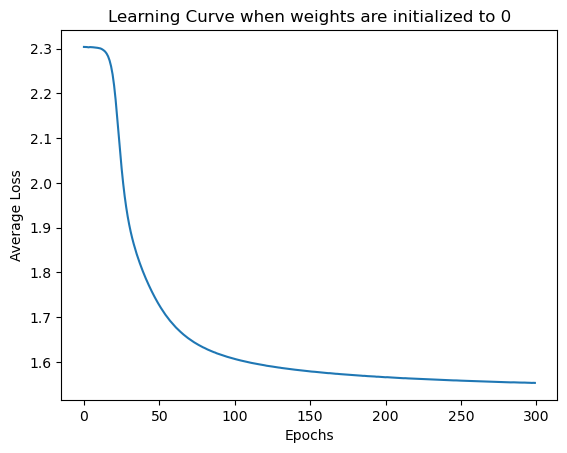

Test accuracy: 38.94999921321869
Test error: 0.6105000078678131


In [110]:
test_acc_0, losses_0 = tf_model(W0=True, epochs = 300)

plt.plot(losses_0)
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Learning Curve when weights are initialized to 0")
plt.show()

print("Test accuracy:", test_acc_0*100)
print("Test error:", 1 - test_acc_0)


## Running tensorflow NN with initialization of weights to random values between -1 and 1

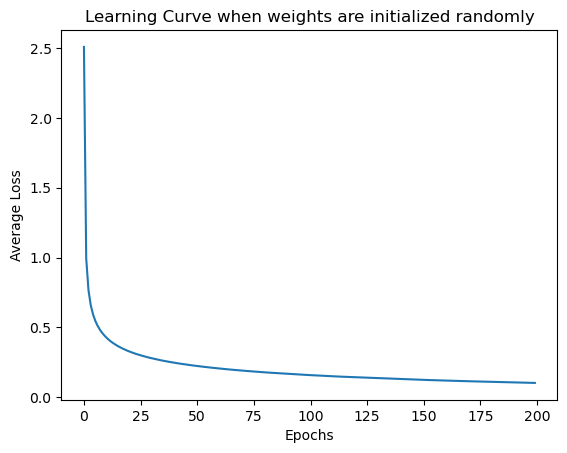

Test accuracy: 95.39999961853027
Test accuracy: 0.046000003814697266


In [106]:
test_acc_uw, losses_uw = tf_model(uni_w=True)

plt.plot(losses_uw)
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Learning Curve when weights are initialized randomly")
plt.show()

print("Test accuracy:", test_acc_uw*100)
print("Test accuracy:", 1-test_acc_uw)


# Question 3
## Naive Bayes

In [36]:
classes = ['e', 'j', 's']
from collections import defaultdict
train_set = defaultdict(list)
for label in classes:
    for rest in range(10):
        filename = f"languageID\\{label}{rest}.txt"
        with open(filename, "r") as f:
            a = f.readlines()
            new_a = []
            for each in a:
                all_of = each.split("\n")
                for one in all_of:
                    new_a.append(one)
            a = [x for x in new_a if x!=""]
            train_set[label].append(a)

In [37]:
# training Naive Bayes
vocab = []
for each in train_set.values():
    for all_c in each:
        # print(sent)
        for sent in all_c:
            for char in sent:
                # print(char)
                vocab.append(char)
vocab = set(list(vocab))
prior = {}
cond_prob = defaultdict(dict)
N = 0
for _,v in train_set.items():
    N += len(v)
unique = len(train_set.keys())
for c in classes:
    class_vocabs = {letter:0 for letter in vocab}
    total_vocab = 0
    prior[c] = (len(train_set[c]) + 0.5) / (N + unique * 0.5)
    for each in train_set[c]:
        for sent in each:
            for char in sent:
                class_vocabs[char] += 1
                total_vocab += 1
    total_vocab += (len(vocab) * 0.5)
    for k, v in class_vocabs.items():
        cond_prob[c][k] = (v+0.5) /total_vocab


In [90]:
prior

{'e': 0.3333333333333333, 'j': 0.3333333333333333, 's': 0.3333333333333333}

### Printing $\theta_e, \theta_j$, and $\theta_s$ for Question 2 and 3

In [41]:
for l in cond_prob:
    print("THETA", l, ":")
    print("Character\t Prob")
    temp_dict = dict(sorted(cond_prob[l].items(), key = lambda k: k[0] ))
    for k,v in temp_dict.items():
        print(k,"\t\t", round(v,2))

THETA e :
Character	 Prob
  		 0.18
a 		 0.06
b 		 0.01
c 		 0.02
d 		 0.02
e 		 0.11
f 		 0.02
g 		 0.02
h 		 0.05
i 		 0.06
j 		 0.0
k 		 0.0
l 		 0.03
m 		 0.02
n 		 0.06
o 		 0.06
p 		 0.02
q 		 0.0
r 		 0.05
s 		 0.07
t 		 0.08
u 		 0.03
v 		 0.01
w 		 0.02
x 		 0.0
y 		 0.01
z 		 0.0
THETA j :
Character	 Prob
  		 0.12
a 		 0.13
b 		 0.01
c 		 0.01
d 		 0.02
e 		 0.06
f 		 0.0
g 		 0.01
h 		 0.03
i 		 0.1
j 		 0.0
k 		 0.06
l 		 0.0
m 		 0.04
n 		 0.06
o 		 0.09
p 		 0.0
q 		 0.0
r 		 0.04
s 		 0.04
t 		 0.06
u 		 0.07
v 		 0.0
w 		 0.02
x 		 0.0
y 		 0.01
z 		 0.01
THETA s :
Character	 Prob
  		 0.17
a 		 0.1
b 		 0.01
c 		 0.04
d 		 0.04
e 		 0.11
f 		 0.01
g 		 0.01
h 		 0.0
i 		 0.05
j 		 0.01
k 		 0.0
l 		 0.05
m 		 0.03
n 		 0.05
o 		 0.07
p 		 0.02
q 		 0.01
r 		 0.06
s 		 0.07
t 		 0.04
u 		 0.03
v 		 0.01
w 		 0.0
x 		 0.0
y 		 0.01
z 		 0.0


### Testing and making test dataset 

In [73]:
test_data = {}
y_labels = []
# classes = ['e', 'j', 's']
for c in classes:
    for rest in range(10, 20):
        name_file = c + str(rest)
        # print(name_file)
        y_labels.append(c)
        filename = f"languageID\\{name_file}.txt"
        with open(filename, "r") as f:
            tt = f.readlines()
            new_tt = []
            for each in tt:
                all_of = each.split("\n")
                for one in all_of:
                    new_tt.append(one)
            tt = [x for x in new_tt if x!=""]
        score = defaultdict(float)
        all_chars = []
        for sent in tt:
            for char in sent:
                all_chars.append(char)
        test_data[name_file] = all_chars

In [57]:
def test_NBC(all_chars, prior, cond_prob):
    for c in classes:
        score[c] = np.log(prior[c])
        for char in all_chars:
            if char in cond_prob[c].keys():
                score[c] += np.log(cond_prob[c][char])
            else:
                print("This char not in vocab")
    final_class = max(score, key = lambda k:score[k])
    return final_class, score

# Answering Question 4, 5, 6 Using e10 

In [58]:
new_bag = defaultdict(int)
all_char  = test_data['e10']
for each in all_chars:
    new_bag[each] += 1
print("Bag of words vector x:")
sorted(new_bag.items(), key = lambda k: k[0] )


Bag of words vector x:


[(' ', 190),
 ('a', 139),
 ('b', 13),
 ('c', 41),
 ('d', 47),
 ('e', 126),
 ('f', 4),
 ('g', 11),
 ('h', 9),
 ('i', 55),
 ('j', 13),
 ('l', 64),
 ('m', 27),
 ('n', 67),
 ('o', 74),
 ('p', 30),
 ('q', 8),
 ('r', 74),
 ('s', 63),
 ('t', 38),
 ('u', 38),
 ('v', 4),
 ('x', 5),
 ('y', 8),
 ('z', 4)]

In [60]:
new_multi = defaultdict(int)
for k,v in new_bag.items():
    for l in cond_prob:
        # print(cond_prob[l][k])
        new_multi[l] += (np.log(cond_prob[l][k]) * v)
print("Probabiliites p(x|y) for all three languages:")
print(new_multi) 

Probabiliites p(x|y) for all three languages:
defaultdict(<class 'int'>, {'e': -3373.4191135625956, 'j': -3744.1349771324235, 's': -3202.7860469521947})


In [61]:
final_class, score = test_NBC(test_data["e10"], prior,cond_prob)
print("Posterior for each langauge given e10.txt:")
print(score)
print("And the final class prediction:")
print(final_class)

Posterior for each langauge given e10.txt:
defaultdict(<class 'float'>, {'e': -7842.964059349239, 'j': -8772.531691363689, 's': -8468.380656299232})
And the final class prediction:
e


100%|██████████| 30/30 [00:00<00:00, 202.46it/s]


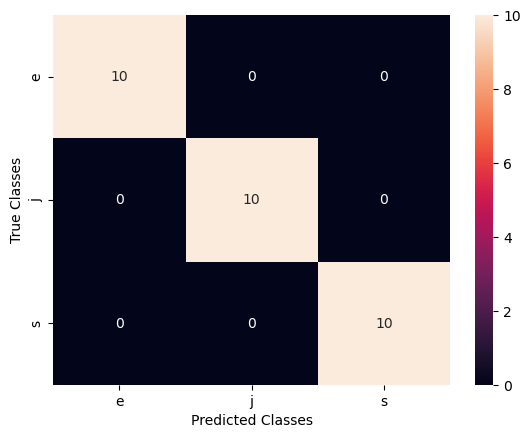

Accuracy: 100.0


In [92]:
y_pred = []
for _, v in tqdm(test_data.items()):
    y_pred.append(test_NBC(v, prior, cond_prob)[0]) 
# print(y_pred)
# print(y_labels)
cm = confusion_matrix(y_labels, y_pred)
sns.heatmap(cm, annot= True, xticklabels=classes, yticklabels= classes)
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")

plt.show()

count_acc = 0
for i in range(len(y_labels)):
    if y_labels[i] == y_pred[i]:
        count_acc += 1
accuracy = count_acc * 100 / len(y_pred) 
print("Accuracy:" , accuracy)